# Project 1: Digit Classification with KNN and Naive Bayes

In this project, you'll implement your own image recognition system for classifying digits. Read through the code and the instructions carefully and add your own code where indicated. Each problem can be addressed succinctly with the included packages -- please don't add any more. Grading will be based on writing clean, commented code, along with a few short answers.

As always, you're welcome to work on the project in groups and discuss ideas on the course wall, but <b> please prepare your own write-up (with your own code). </b>

If you're interested, check out these links related to digit recognition:

* Yann Lecun's MNIST benchmarks: http://yann.lecun.com/exdb/mnist/
* Stanford Streetview research and data: http://ufldl.stanford.edu/housenumbers/

Finally, if you'd like to get started with Tensorflow, you can read through this tutorial: https://www.tensorflow.org/tutorials/keras/basic_classification. It uses a dataset called "fashion_mnist", which is identical in structure to the original digit mnist, but uses images of clothing rather than images of digits. The number of training examples and number of labels is the same. In fact, you can simply replace the code that loads "fashion_mnist" with "mnist" and everything should work fine.

In [1]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# Import a bunch of libraries.
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import MultipleLocator
from sklearn.pipeline import Pipeline
from sklearn.datasets import fetch_openml
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LinearRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

# Set the randomizer seed so results are the same each time.
np.random.seed(0)

In [2]:
import sklearn
sklearn.__version__

'0.22.1'

Load the data. Notice that the data gets partitioned into training, development, and test sets. Also, a small subset of the training data called mini_train_data and mini_train_labels gets defined, which you should use in all the experiments below, unless otherwise noted.

In [3]:
# Load the digit data from https://www.openml.org/d/554 or from default local location '~/scikit_learn_data/...'
X, Y = fetch_openml(name='mnist_784', return_X_y=True, cache=False)


# Rescale grayscale values to [0,1].
X = X / 255.0

# Shuffle the input: create a random permutation of the integers between 0 and the number of data points and apply this
# permutation to X and Y.
# NOTE: Each time you run this cell, you'll re-shuffle the data, resulting in a different ordering.
shuffle = np.random.permutation(np.arange(X.shape[0]))
X, Y = X[shuffle], Y[shuffle]

print('data shape: ', X.shape)
print('label shape:', Y.shape)

# Set some variables to hold test, dev, and training data.
test_data, test_labels = X[61000:], Y[61000:]
dev_data, dev_labels = X[60000:61000], Y[60000:61000]
train_data, train_labels = X[:60000], Y[:60000]
mini_train_data, mini_train_labels = X[:1000], Y[:1000]

data shape:  (70000, 784)
label shape: (70000,)


### Part 1:

Show a 10x10 grid that visualizes 10 examples of each digit.

Notes:
* You can use `plt.rc()` for setting the colormap, for example to black and white.
* You can use `plt.subplot()` for creating subplots.
* You can use `plt.imshow()` for rendering a matrix.
* You can use `np.array.reshape()` for reshaping a 1D feature vector into a 2D matrix (for rendering).

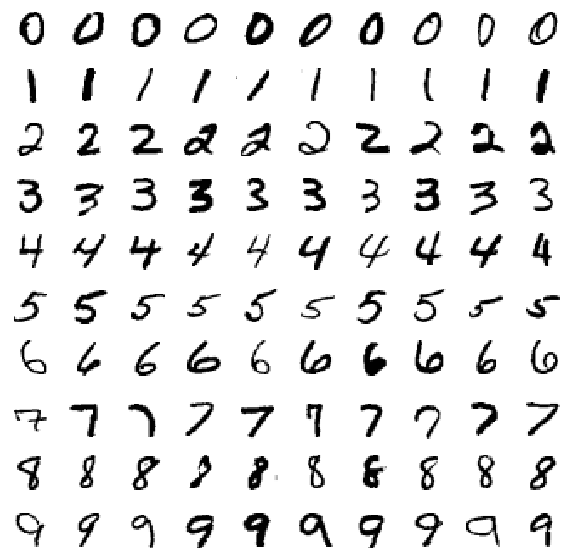

In [16]:
def P1(num_examples=10):
    intY = Y.astype("int") #convert Y to integer to help with iteration
    fig,axs = plt.subplots(10,num_examples,figsize=(10,10))#create subplots
    for digit in np.arange(0,10):#iterate through all 10 digits
        for row in np.arange(0,num_examples):#iterate through number of examples 
            number = X[intY==digit][row].reshape((28,28)) #select rows of X for each digit and convert to square image
            axs[digit,row].imshow(number,cmap="gray_r")#plot
            axs[digit,row].axis('off')
    return
        
P1(10)

### Part 2:

Produce k-Nearest Neighbors models with k $\in$ [1,3,5,7,9].  Evaluate and show the accuracy of each model. For the 1-Nearest Neighbor model, additionally show the precision, recall, and F1 for each label. Which digit is the most difficult for the 1-Nearest Neighbor model to recognize?

Notes:
* Train on the mini train set.
* Evaluate performance on the dev set.
* You can use `KNeighborsClassifier` to produce a k-nearest neighbor model.
* You can use `classification_report` to get precision, recall, and F1 results.

              precision    recall  f1-score   support

           0       0.95      0.95      0.95       106
           1       0.89      0.98      0.93       118
           2       0.90      0.79      0.84       106
           3       0.93      0.87      0.90        97
           4       0.91      0.85      0.88        92
           5       0.86      0.88      0.87        88
           6       0.92      0.92      0.92       102
           7       0.85      0.94      0.89       102
           8       0.83      0.77      0.80        94
           9       0.80      0.86      0.83        95

    accuracy                           0.88      1000
   macro avg       0.88      0.88      0.88      1000
weighted avg       0.89      0.88      0.88      1000



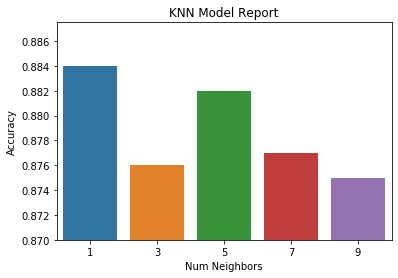

In [5]:
k_values = [1, 3, 5, 7, 9]
def P2(k_values):
    accuracies = []
    for i in np.arange(1,len(k_values)+1):
        model = sklearn.neighbors.KNeighborsClassifier(n_neighbors = k_values[i-1])#create model of specified k
        model.fit(mini_train_data,mini_train_labels)
        y_pred = model.predict(dev_data)
        accuracies.append(sklearn.metrics.accuracy_score(dev_labels,y_pred))
        if (i==1):#save k=1 model's report
            d = classification_report(dev_labels,y_pred)
    sns.barplot(k_values,accuracies)#plot
    plt.ylim(.87,.8875)
    plt.xlabel("Num Neighbors")
    plt.ylabel("Accuracy")
    plt.title("KNN Model Report");
    print(d)
    return 
P2(k_values)

ANSWER: The optimal K for this model is 1, since it has a max accuracy of .884. This is interesting since a lower K means a more complex KNN Classifier. When examining this K=1 case, you can see that the digit "8" is particularly difficult with a precision metric of .80. This means that out of all the positive predicted digits, 80% of "8"s were actually correct 

### Part 3:

Produce 1-Nearest Neighbor models using training data of various sizes.  Evaluate and show the performance of each model.  Additionally, show the time needed to measure the performance of each model.

Notes:
* Train on subsets of the train set.  For each subset, take just the first part of the train set without re-ordering.
* Evaluate on the dev set.
* You can use `KNeighborsClassifier` to produce a k-nearest neighbor model.
* You can use `time.time()` to measure elapsed time of operations.

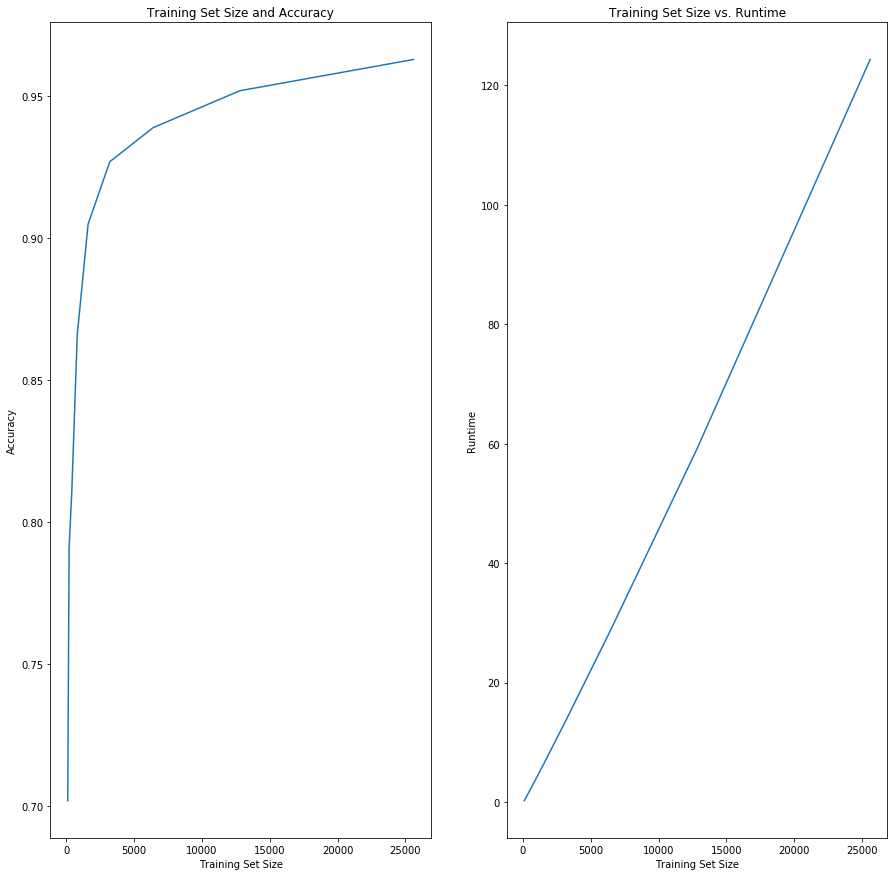

In [34]:
def P3(train_sizes, accuracies):
    
### STUDENT START ###
    starting_time = time.time()
    times = []
    for size in train_sizes:
        model = sklearn.neighbors.KNeighborsClassifier(n_neighbors = 1)#model creation
        model.fit(train_data[:size],train_labels[:size])#fit on subsets of data
        y_pred = model.predict(dev_data)
        accuracies = np.append(accuracies,sklearn.metrics.accuracy_score(dev_labels,y_pred))
        times.append(time.time()-starting_time)#get runtime from relative to starting_time
    fig,axs= plt.subplots(ncols=2,)
    sns.lineplot(train_sizes,accuracies,ax=axs[0])#plot
    sns.lineplot(train_sizes,times,ax=axs[1])
    axs[0].set_title("Training Set Size and Accuracy");
    axs[0].set(xlabel="Training Set Size",ylabel="Accuracy")
    axs[1].set(xlabel="Training Set Size",ylabel="Runtime")
    axs[1].set_title("Training Set Size vs. Runtime")
    return accuracies
### STUDENT END ###

train_sizes = np.array([100, 200, 400, 800, 1600, 3200, 6400, 12800, 25600])#I don't like this here
accuracies = np.array([])#I especially don't like this 
accuracies = P3(train_sizes, accuracies)

### Part 4:

Produce a linear regression model that predicts accuracy of a 1-Nearest Neighbor model given training set size. Show $R^2$ of the linear regression model.  Show the accuracies predicted for training set sizes 60000, 120000, and 1000000.  Show a lineplot of actual accuracies and predicted accuracies vs. training set size over the range of training set sizes in the training data.  What's wrong with using linear regression here?

Apply a transformation to the predictor features and a transformation to the outcome that make the predictions more reasonable.  Show $R^2$ of the improved linear regression model.  Show the accuracies predicted for training set sizes 60000, 120000, and 1000000.  Show a lineplot of actual accuracies and predicted accuracies vs. training set size over the range of training set sizes in the training data - be sure to display accuracies and training set sizes in appropriate units.

Notes:
* Train the linear regression models on all of the (transformed) accuracies estimated in Problem 3.
* Evaluate the linear regression models on all of the (transformed) accuracies estimated in Problem 3.
* You can use `LinearRegression` to produce a linear regression model.
* Remember that the sklearn `fit()` functions take an input matrix X and output vector Y. So, each input example in X is a vector, even if it contains only a single value.
* Hint re: predictor feature transform: Accuracy increases with training set size logarithmically.
* Hint re: outcome transform: When y is a number in range 0 to 1, then odds(y)=y/(1-y) is a number in range 0 to infinity.

Rsquared score: -0.4969155082883163
predicted accuracies for 60,000: 0.4471925578321244
predicted accuracies for 120,000: 0.3791572621747788
predicted accuracies for 1,000,000: 0.1173364668660436


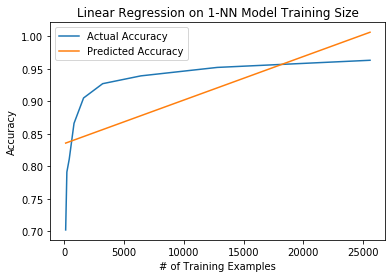

In [7]:
def P4():
    lin_reg_model = sklearn.linear_model.LinearRegression()
    lin_reg_model.fit(train_sizes.reshape((-1,1)),accuracies.reshape((-1,1)))#since 1 feature and label, need to reshape
    r2 = sklearn.metrics.r2_score(train_sizes.reshape((-1,1)),accuracies.reshape((-1,1)))#calculate r^2
    predicted_set_accuracies = 1/(1+lin_reg_model.predict(set_sizes.reshape(-1,1)))#accuracies for 60k,120k,1000k
    p4accuracies = lin_reg_model.predict(train_sizes.reshape((-1,1)))
    p4accuracies = p4accuracies.reshape((1,9))[0]
    print("Rsquared score: " + str(r2))
    print("predicted accuracies for 60,000: "+ str(predicted_set_accuracies[0][0]))
    print("predicted accuracies for 120,000: "+ str(predicted_set_accuracies[1][0]))
    print("predicted accuracies for 1,000,000: "+ str(predicted_set_accuracies[2][0]))
    sns.lineplot(train_sizes,accuracies,label ="Actual Accuracy")#plot
    sns.lineplot(train_sizes,p4accuracies,label = "Predicted Accuracy");
    plt.xlabel("# of Training Examples")
    plt.ylabel("Accuracy")
    plt.title("Linear Regression on 1-NN Model Training Size");
    return
    
set_sizes = np.array([60000,120000,1000000])#I don't like this here
P4()

The R^2 Score is 0.9068304252436642
predicted accuracies for 60,000: 0.49174171021361573
predicted accuracies for 120,000: 0.48442072667286673
predicted accuracies for 1,000,000: 0.46332091068015635


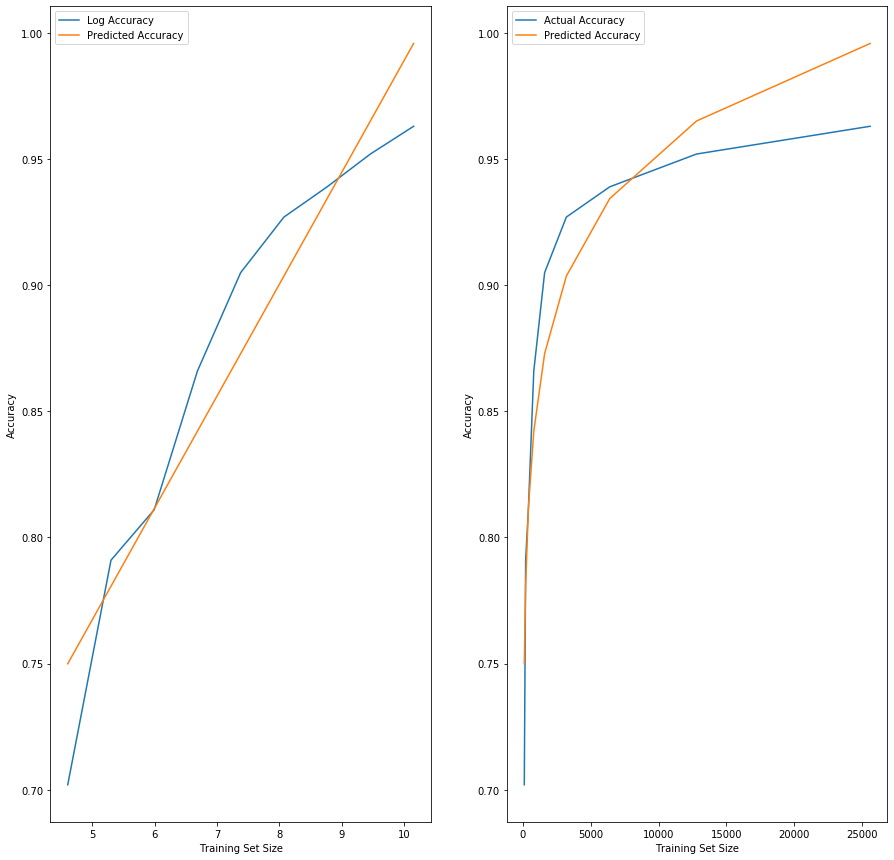

In [167]:
def P4log(): #make a function for log
    log_train = np.log(train_sizes)#apply log 
    lin_reg_model_transformed = sklearn.linear_model.LinearRegression()#rest is same as P4
    lin_reg_model_transformed.fit(log_train.reshape((-1,1)),accuracies.reshape((-1,1)))
    predicted_test_accuracies_transformed = 1/(1+lin_reg_model_transformed.predict(np.log(set_sizes).reshape(-1,1)).reshape((1,3))[0])# make output in range of 
    output = lin_reg_model_transformed.predict(log_train.reshape((-1,1)))
    r2transformed = sklearn.metrics.r2_score(accuracies,output)
    print("The R^2 Score is " + str(r2transformed))
    print("predicted accuracies for 60,000: "+ str(predicted_test_accuracies_transformed[0]))
    print("predicted accuracies for 120,000: "+ str(predicted_test_accuracies_transformed[1]))
    print("predicted accuracies for 1,000,000: "+ str(predicted_test_accuracies_transformed[2]))
    fig,axs = plt.subplots(ncols=2,figsize=(15,15))
    sns.lineplot(log_train,accuracies,label = "Log Accuracy",ax=axs[0])
    sns.lineplot(log_train,output.reshape((1,9))[0],label = "Predicted Accuracy",ax=axs[0])
    sns.lineplot(train_sizes,accuracies,label = "Actual Accuracy",ax=axs[1])
    sns.lineplot(train_sizes,output.reshape((1,9))[0],label = "Predicted Accuracy",ax=axs[1])
    axs[0].set(xlabel="Training Set Size",ylabel="Accuracy")
    axs[1].set(xlabel="Training Set Size",ylabel="Accuracy")
    return
P4log()

ANSWER:Using linear regression when the target variable increases logarithmically means that the error between the line of best fit and the actual accuracy results in a negative r^2 score. If we apply a log to our input, our R^2 score becomes much better and we can see that our line of best fit more closely approximates the data!

### Part 5:

Produce a 1-Nearest Neighbor model and show the confusion matrix. Which pair of digits does the model confuse most often? Show the images of these most often confused digits.

Notes:
- Train on the mini train set.
- Evaluate performance on the dev set.
- You can use `confusion_matrix()` to produce a confusion matrix.

[[101   0   1   0   0   0   1   1   2   0]
 [  0 116   1   0   0   0   0   0   1   0]
 [  1   4  84   2   2   0   2   4   6   1]
 [  0   2   0  84   0   6   0   2   3   0]
 [  0   0   1   0  78   0   0   2   0  11]
 [  2   0   0   1   1  77   5   0   2   0]
 [  1   2   1   0   1   2  94   0   1   0]
 [  0   1   1   0   0   0   0  96   0   4]
 [  1   5   4   3   1   3   0   1  72   4]
 [  0   1   0   0   3   2   0   7   0  82]]


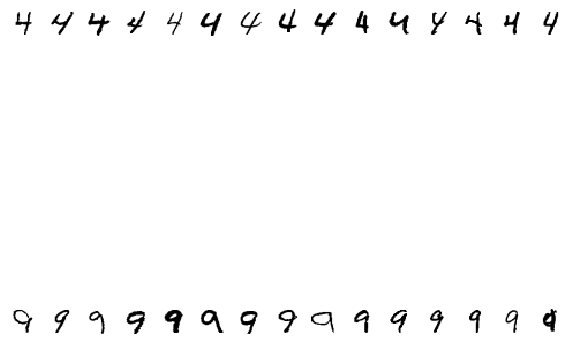

In [41]:
def P5(num_examples):
    p5model = sklearn.neighbors.KNeighborsClassifier(n_neighbors = 1)
    p5model.fit(mini_train_data,mini_train_labels)
    predicted_dev_labels = p5model.predict(dev_data)
    print(sklearn.metrics.confusion_matrix(dev_labels,predicted_dev_labels))#create confusion matrix
    fours = X[Y=="4"]#rows of digit 4
    nines = X[Y=="9"]#rows of digit 9 
    fig,axs = plt.subplots(2,num_examples,figsize=(10,10))
    for i,x in enumerate([fours,nines]):
        for y in np.arange(0,num_examples):
            digit = x[y].reshape((28,28))#make square image
            axs[i,y].imshow(digit,cmap="gray_r")
            axs[i,y].axis('off')
    return

P5(15)

### ANSWER:
According to the documentation, the (i,j) row-column pair entry represents the number of true label(i) prediction (j) pairs. As expected, values along the diagonal represent true positives and are significantly larger in magnitude than most of the other non diagonal entries in the matrix. The model confuses a written 4 for a 9 the most times relative to other erroneous classifications. This makes sense. 

### Part 6:

A common image processing technique is to smooth an image by blurring. The idea is that the value of a particular pixel is estimated as the weighted combination of the original value and the values around it. Typically, the blurring is Gaussian, i.e., the weight of a pixel's influence is determined by a Gaussian function over the distance to the relevant pixel.

Implement a simplified Gaussian blur filter by just using the 8 neighboring pixels like this: the smoothed value of a pixel is a weighted combination of the original value and the 8 neighboring values.

Pick a weight, then produce and evaluate four 1-Nearest Neighbor models by applying your blur filter in these ways:
- Do not use the filter
- Filter the training data but not the dev data
- Filter the dev data but not the training data
- Filter both training data and dev data

Show the accuracies of the four models evaluated as described.  Try to pick a weight that makes one model's accuracy at least 0.9.

Notes:
* Train on the (filtered) mini train set.
* Evaluate performance on the (filtered) dev set.
* There are other Guassian blur filters available, for example in `scipy.ndimage.filters`. You are welcome to experiment with those, but you are likely to get the best results with the simplified version described above.

'Runtime: 45 Seconds'

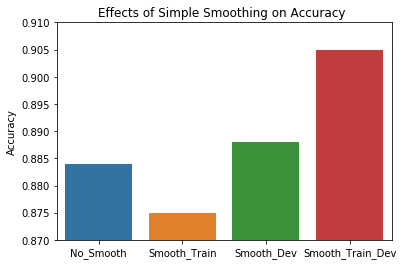

In [328]:
def P6():
    starting_time = time.time()
    def smooth(img,weight=8):
        #takes in a (28x28) image
        #returns a smoothed (28x28) image
        square=img.reshape(28,28)
        smoothed = np.zeros((28,28)) #instanciate an empty plot
        for idr,row in enumerate(square[1:28]):#
            for idp,pixel in enumerate(row[1:28]):
                new_value = pixel
                for i in np.arange(-1,2):#iterate through 8 surrounding pixels 
                    for j in np.arange(-1,2):
                        new_value += square[idr+i][idp+j]
                smoothed[idr][idp] = new_value/weight #weight new value
        return smoothed.reshape(784)

    filtered_training = np.apply_along_axis(smooth, 1, mini_train_data) #smooth train and dev set
    filtered_dev = np.apply_along_axis(smooth, 1, dev_data)
    
    def eval_p6(train,dev):
        #Evaluates model using different generalized datasets
        model = sklearn.neighbors.KNeighborsClassifier(n_neighbors=1)
        model.fit(train,mini_train_labels)
        y_predict = model.predict(dev)
        return sklearn.metrics.accuracy_score(dev_labels,y_predict)

    accuracies = []
    models = ["No_Smooth","Smooth_Train","Smooth_Dev","Smooth_Train_Dev"]
    train_sets = [mini_train_data,filtered_training,mini_train_data,filtered_training]
    dev_sets = [dev_data,dev_data,filtered_dev,filtered_dev]
    for model in zip(models,train_sets,dev_sets): #iterate through models filter combos and find accuracy
        accuracies.append(eval_p6(model[1],model[2]))
    sns.barplot(models,accuracies)#plot
    plt.ylim(.87,.91)
    plt.ylabel("Accuracy")
    plt.title("Effects of Simple Smoothing on Accuracy ")
    return "Runtime: " + str(round(time.time() - starting_time)) + " Seconds"#Runtime of function
P6()

### Part 7:

Produce two Naive Bayes models and evaluate their performances.  Recall that Naive Bayes estimates P(feature|label), where each label is a categorical, not a real number.

For the first model, map pixel values to either 0 or 1, representing white or black - you should pre-process the data or use `BernoulliNB`'s `binarize` parameter to set the white/black separation threshold to 0.1.  Use `BernoulliNB` to produce the model.

For the second model, map pixel values to either 0, 1, or 2, representing white, gray, or black - you should pre-process the data, seting the white/gray/black separation thresholds to 0.1 and 0.9.  Use `MultinomialNB` to produce the model. 

Show the Bernoulli model accuracy and the Multinomial model accuracy.

Notes:
* Train on the mini train set.
* Evaluate performance on the dev set.
* `sklearn`'s Naive Bayes methods can handle real numbers, but for this exercise explicitly do the mapping to categoricals. 

Does the multinomial version improve the results? Why or why not?

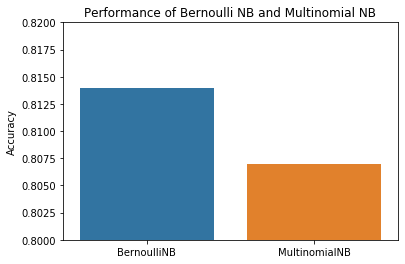

In [202]:
def P7():
    def bin_data(dataset,bins):
        #converts image to specified bins
        copied = np.zeros(dataset.shape)
        for i in range(len(dataset)):
            copied[i] = np.digitize(dataset[i],bins)
        return copied
        
    BernoulliModel = sklearn.naive_bayes.BernoulliNB(binarize=0.1)#instanciate models
    MultinomialModel = sklearn.naive_bayes.MultinomialNB()
    models = [BernoulliModel,MultinomialModel]
    accuracies = []
    binned_train = [bin_data(mini_train_data,[.1]),bin_data(mini_train_data,[.1,.9])]
    binned_dev = [bin_data(dev_data,[.1]),bin_data(dev_data,[.1,.9])]
    #binned_dev = [dev_data,dev_data]
    for model,data,dev in zip(models,binned_train,binned_dev):#iterate through models and get accuracies
        model.fit(data,mini_train_labels)
        y_predict = model.predict(dev)
        accuracies.append(sklearn.metrics.accuracy_score(dev_labels,y_predict))
    sns.barplot(["BernoulliNB","MultinomialNB"],accuracies)#plot
    plt.ylim(.8,.82)
    plt.ylabel("Accuracy")
    plt.title("Performance of Bernoulli NB and Multinomial NB")
    return 
    
    
    

P7()

ANSWER: The Multinomial NB did not outperform the Bernoulli NB which makes sense because it's not really the best model to use in this situation. When we bin the data for both models, a binary "either black or not black" pixel bin reduces variance when evaluating on the dev set. Binning by [0,1,2] doesn't give you any more information than binning by [0,1]

### Part 8:

Search across several values of the LaPlace smoothing parameter (alpha) to find its effect on a Bernoulli Naive Bayes model's performance.  Show the accuracy at each alpha value.

Notes:
* Set binarization threshold to 0.
* Train on the mini train set.
* Evaluate performance by 5-fold cross-validation. 
* Use `GridSearchCV(..., ..., cv=..., scoring='accuracy', iid=False)` to vary alpha and evaluate performance by cross-validation.
* Cross-validation is based on partitions of the training data, so results will be a bit different than if you had used the dev set to evaluate performance.

What is the best value for alpha? What is the accuracy when alpha is near 0? Is this what you'd expect?

Best alpha =  {'alpha': 0.001}


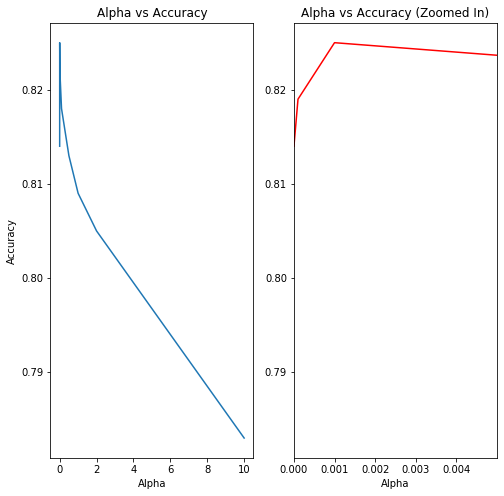

In [245]:
alphas = {'alpha': [1.0e-10, 0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 10.0]}
def P8(alphas):
    gridsearch = GridSearchCV(estimator=sklearn.naive_bayes.BernoulliNB(binarize=0),
                         param_grid=alphas,
                         cv=None,
                         scoring="accuracy")
    gridsearch.fit(mini_train_data,mini_train_labels)
    mean_accuracies = gridsearch.cv_results_["mean_test_score"]# use average accuracy across all digits
    fig,axs = plt.subplots(ncols=2,figsize=(8,8))#plot
    sns.lineplot(alphas["alpha"],mean_accuracies,ax=axs[0])
    sns.lineplot(alphas["alpha"],mean_accuracies,ax=axs[1],color="red")
    axs[1].set_xlim(0,.005)
    axs[1].set_xticks(np.arange(0,.005,.001))
    axs[0].set(xlabel="Alpha",ylabel="Accuracy")
    axs[1].set(xlabel="Alpha")
    axs[0].set_title("Alpha vs Accuracy")
    axs[1].set_title("Alpha vs Accuracy (Zoomed In)")
    print("Best alpha = ", gridsearch.best_params_)
    return 
P8(alphas)

ANSWER:The best value for alpha is .001. The accuracy when alpha tends to 0 is around 81% which makes sense, since the last problem's Bernoulli NB model had an accuracy of around 81.4%. 

### Part 9:

Produce a model using Guassian Naive Bayes, which is intended for real-valued features, and evaluate performance. You will notice that it does not work so well. Diagnose the problem and apply a simple fix so that the model accuracy is around the same as for a Bernoulli Naive Bayes model. Show the model accuracy before your fix and the model accuracy after your fix.  Explain your solution.

Notes:
* Train on the mini train set.
* Evaluate performance on the dev set.
* Consider the effects of theta and sigma.  These are stored in the model's `theta_` and `sigma_` attributes.

0.593


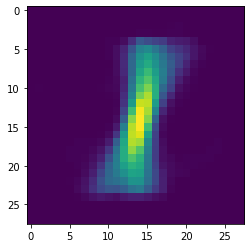

In [307]:
def P9():
    GaussModel = sklearn.naive_bayes.GaussianNB()#instanciate model
    GaussModel.fit(mini_train_data,mini_train_labels)
    initial_accuracy = sklearn.metrics.accuracy_score(dev_labels,GaussModel.predict(dev_data))#accuracy with no fix
    print(initial_accuracy)
    return plt.imshow(GaussModel.theta_[1].reshape((28,28)))
    

P9()

ANSWER:

### Part 10:

Because Naive Bayes produces a generative model, you can use it to generate digit images.

Produce a Bernoulli Naive Bayes model and then use it to generate a 10x20 grid with 20 example images of each digit. Each pixel output should be either 0 or 1, based on comparing some randomly generated number to the estimated probability of the pixel being either 0 or 1.  Show the grid.

Notes:
* You can use np.random.rand() to generate random numbers from a uniform distribution.
* The estimated probability of each pixel being 0 or 1 is stored in the model's `feature_log_prob_` attribute. You can use `np.exp()` to convert a log probability back to a probability.

How do the generated digit images compare to the training digit images?

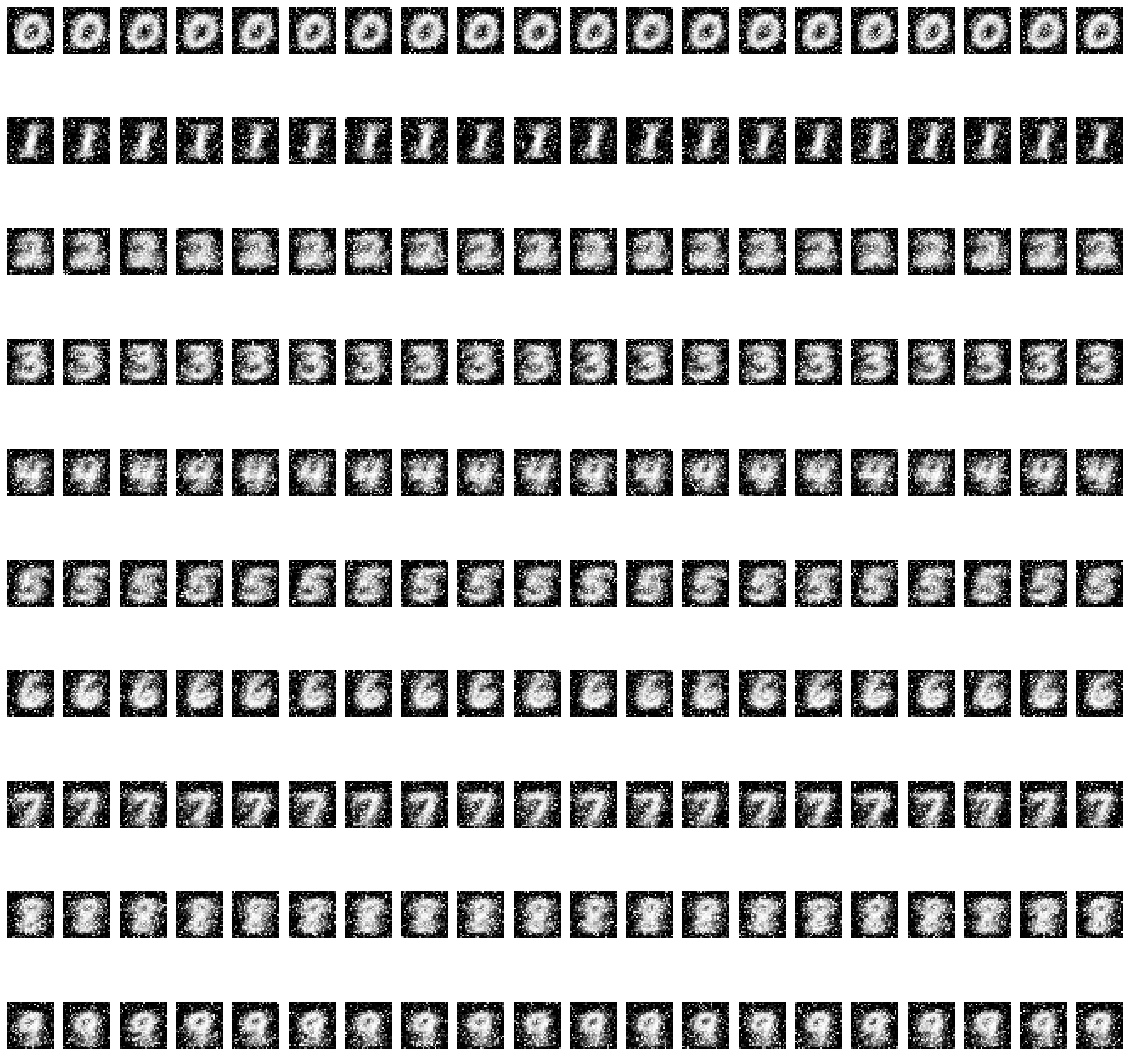

In [308]:
def P10(num_examples):
    fig,axs = plt.subplots(10,num_examples,figsize=(20,20))
    model = sklearn.naive_bayes.BernoulliNB(binarize=0.1,alpha=.001)#instanciate model
    model.fit(mini_train_data,mini_train_labels)
    for digit,digit_prob in enumerate(model.feature_log_prob_):#iterate through likelihoods
        for n in np.arange(num_examples):
            img = np.exp(digit_prob*np.random.rand(784)).reshape((28,28))#generate different images each 
                                                                        #time by multiplying by random array
            axs[digit,n].imshow(img,cmap="gray")#plot
            axs[digit,n].axis('off')
    return 

P10(20)

ANSWER:The generated digits up close look...suboptimal, but from far away they capture the essence of what the digit looks like. For all the generated digits, the majority of points are correct!

### Part 11:

Recall that a strongly calibrated classifier is rougly 90% accurate when the posterior probability of the predicted class is 0.9. A weakly calibrated classifier is more accurate when the posterior probability of the predicted class is 90% than when it is 80%. A poorly calibrated classifier has no positive correlation between posterior probability and accuracy.  

Produce a Bernoulli Naive Bayes model.  Evaluate performance: partition the dev set into several buckets based on the posterior probabilities of the predicted classes - think of a bin in a histogram- and then estimate the accuracy for each bucket. So, for each prediction, find the bucket to which the maximum posterior probability belongs, and update "correct" and "total" counters accordingly.  Show the accuracy for each bucket.

Notes:
* Set LaPlace smoothing (alpha) to the optimal value (from part 8).
* Set binarization threshold to 0.
* Train on the mini train set.
* Evaluate perfromance on the dev set.

How would you characterize the calibration for this Bernoulli Naive Bayes model?

In [327]:
def P11(buckets, correct, total):
    model = sklearn.naive_bayes.BernoulliNB(binarize=0,alpha=.001)#instanciate model
    model.fit(mini_train_data,mini_train_labels)
    y_predict = model.predict_proba(dev_data)#each element is the posterior P(class|data)
    for index,prediction in enumerate(y_predict):
        max_index = np.argmax(prediction)#predicted digit
        bin_number = np.digitize(prediction,buckets)[max_index]
        if (max_index == int(dev_labels[index])):#check predicted == actual
            correct[bin_number-1]+=1
        total[bin_number-1]+=1        
    return

buckets = [0.5, 0.9, 0.999, 0.99999, 0.9999999, 0.999999999, 0.99999999999, 0.9999999999999, 1.0]
correct = [0 for i in buckets]
total = [0 for i in buckets]

P11(buckets, correct, total)
for i in range(len(buckets)):
    accuracy = 0.0
    if (total[i] > 0): accuracy = correct[i] / total[i]
    print('p(pred) is %.13f to %.13f    total = %3d    accuracy = %.3f' % (0 if i==0 else buckets[i-1], buckets[i], total[i], accuracy))

p(pred) is 0.0000000000000 to 0.5000000000000    total =  31    accuracy = 0.355
p(pred) is 0.5000000000000 to 0.9000000000000    total =  67    accuracy = 0.433
p(pred) is 0.9000000000000 to 0.9990000000000    total =  59    accuracy = 0.458
p(pred) is 0.9990000000000 to 0.9999900000000    total =  46    accuracy = 0.652
p(pred) is 0.9999900000000 to 0.9999999000000    total =  62    accuracy = 0.774
p(pred) is 0.9999999000000 to 0.9999999990000    total =  33    accuracy = 0.788
p(pred) is 0.9999999990000 to 0.9999999999900    total =  43    accuracy = 0.791
p(pred) is 0.9999999999900 to 0.9999999999999    total =  19    accuracy = 0.842
p(pred) is 0.9999999999999 to 1.0000000000000    total = 640    accuracy = 0.941


ANSWER: Since our accuracy increase as we consider the posterior probabilites closer to 1, our classifier is weakly calibrated. Also, when our posterior probability is .9-.99, our accuracy is .458. Yikes, it's not strongly calibrated. 